In [1]:
%pip install yfinance pandas_ta scikit-learn matplotlib statsmodels


  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py) ... done
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 51.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 19.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.

In [2]:

import yfinance as yf
import statsmodels.api as sm

symbols = [
  "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
  "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
  "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
  "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
  "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS",
  "INDUSINDBK.NS", "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LTIM.NS",
  "LT.NS", "M&M.NS", "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS",
  "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
  "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS",
  "TECHM.NS", "TITAN.NS", "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]


df = yf.download(symbols, start="2000-01-01")['Close'].dropna()

# df = yf.download(symbols, interval="1m", period="7d")['Close'].dropna()

print(df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  50 of 50 completed

Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2017-11-17    83.979088     384.685059    1029.646362    1109.959839   
2017-11-20    86.016914     382.430389    1034.282837    1105.269165   
2017-11-21    82.289848     384.541107    1081.331055    1099.536011   
2017-11-22    84.622604     397.685364    1122.034790    1112.802856   
2017-11-23    81.780403     390.585571    1112.322388    1098.872681   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2017-11-17   539.377075    2637.366455     511.470184    1749.120972   
2017-11-20   542.111816    2666.273926     515.837341    1766.638184   
2017-11-21   543.752625    2714.179932     519.092773    1771.041992   
2017-11-22   537.487671    2724.830078     516.116577    1736.007812   
2017-11-23   541.117371    2684.901367     511.853973    1725.9

In [3]:
# Filtering out correlated stocks.

filtered_pairs = []
corr_matrix = df.corr()
corr_threshold = 0.8

for i in range(len(symbols)):
  for j in range(i + 1, len(symbols)):
    s1, s2 = symbols[i], symbols[j]
    corr = corr_matrix.loc[s1, s2]
    if corr > corr_threshold:
      filtered_pairs.append((s1, s2, corr))

# Sort by correlation
filtered_pairs.sort(key=lambda x: x[2], reverse=True)

# Output top correlated pairs
for s1, s2, corr in filtered_pairs:
  print(f"{s1} & {s2} → Corr: {corr}")

COALINDIA.NS & NTPC.NS → Corr: 0.9846086050628424
NTPC.NS & POWERGRID.NS → Corr: 0.9840078843985001
POWERGRID.NS & SUNPHARMA.NS → Corr: 0.9803149264562355
BAJFINANCE.NS & BAJAJFINSV.NS → Corr: 0.9757600556652002
COALINDIA.NS & ONGC.NS → Corr: 0.9754560533761198
GRASIM.NS & ULTRACEMCO.NS → Corr: 0.9741183089181884
BHARTIARTL.NS & SUNPHARMA.NS → Corr: 0.9737074090692484
GRASIM.NS & HINDALCO.NS → Corr: 0.9736486819044752
BAJAJ-AUTO.NS & NTPC.NS → Corr: 0.9736185289251361
APOLLOHOSP.NS & HCLTECH.NS → Corr: 0.9733475875412658
INFY.NS & TCS.NS → Corr: 0.9732940079347968
BAJAJ-AUTO.NS & POWERGRID.NS → Corr: 0.972915699422794
HCLTECH.NS & ULTRACEMCO.NS → Corr: 0.9721985436140793
GRASIM.NS & SBIN.NS → Corr: 0.9710168537551748
APOLLOHOSP.NS & ICICIBANK.NS → Corr: 0.970947353473126
ICICIBANK.NS & SBIN.NS → Corr: 0.9708060991070635
INFY.NS & LTIM.NS → Corr: 0.969844563512426
LT.NS & NTPC.NS → Corr: 0.9690287690603706
APOLLOHOSP.NS & JSWSTEEL.NS → Corr: 0.968563274805803
ICICIBANK.NS & ULTRACEMCO.N

In [4]:
# Filtering the co-integrated stocks

import pandas as pd
from statsmodels.tsa.stattools import coint

# Taking only 20 highest correlated stocks
# We can change it according to our needs.
filtered_pairs = filtered_pairs[:50]

co_integrated_pairs = []

for stock1, stock2, _ in filtered_pairs:
  prices1 = df[stock1].dropna()
  prices2 = df[stock2].dropna()
  
  # Align on common dates
  combined = pd.concat([prices1, prices2], axis=1).dropna()
  prices1_aligned = combined.iloc[:, 0]
  prices2_aligned = combined.iloc[:, 1]
  
  # Run cointegration test
  _, p_coint, _ = coint(prices1_aligned, prices2_aligned)
  if p_coint < 0.05:
    co_integrated_pairs.append((stock1, stock2, round(p_coint, 4)))

# Sorting by strongest co-integration
co_integrated_pairs.sort(key=lambda x: x[2])

for s1, s2, p in co_integrated_pairs:
  print(f"{s1} & {s2} → Cointegration p-value: {p}")

  


GRASIM.NS & HINDALCO.NS → Cointegration p-value: 0.0002
HCLTECH.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0023
ADANIPORTS.NS & CIPLA.NS → Cointegration p-value: 0.0034
RELIANCE.NS & TATACONSUM.NS → Cointegration p-value: 0.0035
EICHERMOT.NS & M&M.NS → Cointegration p-value: 0.0068
APOLLOHOSP.NS & ULTRACEMCO.NS → Cointegration p-value: 0.009
BAJAJ-AUTO.NS & POWERGRID.NS → Cointegration p-value: 0.0093
APOLLOHOSP.NS & JSWSTEEL.NS → Cointegration p-value: 0.0096
NTPC.NS & POWERGRID.NS → Cointegration p-value: 0.0187
POWERGRID.NS & SUNPHARMA.NS → Cointegration p-value: 0.0221
COALINDIA.NS & ONGC.NS → Cointegration p-value: 0.0237
APOLLOHOSP.NS & TITAN.NS → Cointegration p-value: 0.0237
SBIN.NS & TATASTEEL.NS → Cointegration p-value: 0.0256
HINDALCO.NS & JSWSTEEL.NS → Cointegration p-value: 0.0271
APOLLOHOSP.NS & TCS.NS → Cointegration p-value: 0.0287
NTPC.NS & ONGC.NS → Cointegration p-value: 0.0336
SBIN.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0375
CIPLA.NS & HCLTECH.NS → Cointeg

In [5]:
print(co_integrated_pairs)

[('GRASIM.NS', 'HINDALCO.NS', np.float64(0.0002)), ('HCLTECH.NS', 'ULTRACEMCO.NS', np.float64(0.0023)), ('ADANIPORTS.NS', 'CIPLA.NS', np.float64(0.0034)), ('RELIANCE.NS', 'TATACONSUM.NS', np.float64(0.0035)), ('EICHERMOT.NS', 'M&M.NS', np.float64(0.0068)), ('APOLLOHOSP.NS', 'ULTRACEMCO.NS', np.float64(0.009)), ('BAJAJ-AUTO.NS', 'POWERGRID.NS', np.float64(0.0093)), ('APOLLOHOSP.NS', 'JSWSTEEL.NS', np.float64(0.0096)), ('NTPC.NS', 'POWERGRID.NS', np.float64(0.0187)), ('POWERGRID.NS', 'SUNPHARMA.NS', np.float64(0.0221)), ('COALINDIA.NS', 'ONGC.NS', np.float64(0.0237)), ('APOLLOHOSP.NS', 'TITAN.NS', np.float64(0.0237)), ('SBIN.NS', 'TATASTEEL.NS', np.float64(0.0256)), ('HINDALCO.NS', 'JSWSTEEL.NS', np.float64(0.0271)), ('APOLLOHOSP.NS', 'TCS.NS', np.float64(0.0287)), ('NTPC.NS', 'ONGC.NS', np.float64(0.0336)), ('SBIN.NS', 'ULTRACEMCO.NS', np.float64(0.0375)), ('CIPLA.NS', 'HCLTECH.NS', np.float64(0.0395)), ('ADANIPORTS.NS', 'SBIN.NS', np.float64(0.0399)), ('GRASIM.NS', 'SBIN.NS', np.float6

In [6]:
"""
# Before moving to another step of using OLS to find beta. It is important to identify the dependent and independent stock.

Say you are analyzing:
- Stock A: ICICIBANK (stable, large-cap, low volatility)
- Stock B: HDFCBANK (more volatile)

Wrong Way:
-----------
- ICICIBANK = alpha + beta * HDFCBANK
- You're trying to model how the stable stock depends on the noisy one.

This gives:
- Poor beta
- Non-stationary spread
- Bad trading signals

Right Way:
-----------
- HDFCBANK = alpha + beta * ICICIBANK
- You're modeling how the noisier stock reacts to the stable one.

This gives:
- Accurate hedge ratio (β)
- Clean, mean-reverting spread
- Reliable entry/exit signals
"""

from statsmodels.tsa.stattools import adfuller, kpss

tradable_pairs = []

for stockOne, stockTwo, _ in co_integrated_pairs:

  dependentStock = None
  independentStock = None

  dailyReturns = df.pct_change().dropna()
  volatilityStockOne = dailyReturns[stockOne].std()
  volatilityStockTwo = dailyReturns[stockTwo].std()
  
  if volatilityStockOne > volatilityStockTwo:
    dependentStock = stockOne
    independentStock = stockTwo
  else:
    dependentStock = stockTwo
    independentStock = stockOne
  
  X = sm.add_constant(df[independentStock])
  model = sm.OLS(df[dependentStock], X).fit()
  beta = model.params[independentStock]
  
  spread = df[dependentStock] - beta * df[independentStock]

  adf_p_value = adfuller(spread)[1]
  kpss_p_value = kpss(spread, regression='c')[1]
  
  print(f'Dependent Stock = {dependentStock}, Independent Stock = {independentStock}, Beta = {beta}, ADF p-value = {adf_p_value}, KPSS p-value = {kpss_p_value}')

  if adf_p_value < 0.05 and kpss_p_value > 0.05:
    tradable_pairs.append((dependentStock, independentStock))
    
print(tradable_pairs)


Dependent Stock = HINDALCO.NS, Independent Stock = GRASIM.NS, Beta = 0.26304608293705767, ADF p-value = 1.4460220157800187e-05, KPSS p-value = 0.02508517543790619
Dependent Stock = ULTRACEMCO.NS, Independent Stock = HCLTECH.NS, Beta = 5.817314829919756, ADF p-value = 0.0005340649569222206, KPSS p-value = 0.1
Dependent Stock = ADANIPORTS.NS, Independent Stock = CIPLA.NS, Beta = 0.950553990485832, ADF p-value = 0.0006068336044709504, KPSS p-value = 0.1
Dependent Stock = TATACONSUM.NS, Independent Stock = RELIANCE.NS, Beta = 0.9088844895056846, ADF p-value = 0.001279623833282611, KPSS p-value = 0.011383526161341095
Dependent Stock = M&M.NS, Independent Stock = EICHERMOT.NS, Beta = 0.708079270335993, ADF p-value = 0.0017477510351760939, KPSS p-value = 0.0462550864273826
Dependent Stock = APOLLOHOSP.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.7641962160556804, ADF p-value = 0.0018193989247977755, KPSS p-value = 0.01
Dependent Stock = BAJAJ-AUTO.NS, Independent Stock = POWERGRID.NS, Beta

/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: Th

Dependent Stock = TATASTEEL.NS, Independent Stock = SBIN.NS, Beta = 0.24899241008008505, ADF p-value = 0.0055532002316958625, KPSS p-value = 0.03809147616988937
Dependent Stock = HINDALCO.NS, Independent Stock = JSWSTEEL.NS, Beta = 0.62175346782734, ADF p-value = 0.006490141504399292, KPSS p-value = 0.1
Dependent Stock = APOLLOHOSP.NS, Independent Stock = TCS.NS, Beta = 2.187272709513892, ADF p-value = 0.0069591182444633986, KPSS p-value = 0.01
Dependent Stock = ONGC.NS, Independent Stock = NTPC.NS, Beta = 0.6178579913341625, ADF p-value = 0.0057268894132525335, KPSS p-value = 0.01
Dependent Stock = SBIN.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.07433228228677398, ADF p-value = 0.009528560084763115, KPSS p-value = 0.04080056704771825
Dependent Stock = HCLTECH.NS, Independent Stock = CIPLA.NS, Beta = 1.1812453867200665, ADF p-value = 0.002803212419174228, KPSS p-value = 0.1
Dependent Stock = ADANIPORTS.NS, Independent Stock = SBIN.NS, Beta = 1.6655311425938981, ADF p-value = 0.010

/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/1443997780.py:56: InterpolationWarning: Th

In [7]:
print(f'Tradable Pairs are {tradable_pairs}')


Tradable Pairs are [('ULTRACEMCO.NS', 'HCLTECH.NS'), ('ADANIPORTS.NS', 'CIPLA.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS'), ('HCLTECH.NS', 'CIPLA.NS'), ('ADANIPORTS.NS', 'SBIN.NS')]



# ## You can use below code for individual co-integrated stocks


In [8]:
import statsmodels.api as sm

# Using OLS to find the value of beta


# Just replace these values with stock tickers only to test for individual pairs.
dependentStock = 'ULTRACEMCO.NS'
independentStock = 'HCLTECH.NS'


X = sm.add_constant(df[independentStock])
model = sm.OLS(df[dependentStock], X).fit()
beta = model.params[independentStock]
print(f'Beta = {beta}')


# Now as we already found beta, we have to find the spread which is given by
# spread = stockOne - beta * stockTwo

# We could also calculate the value of spread as stockOne - stockTwo but
# that would not be sufficient, because this works only if both have similar price scales and volatilities — which is rare.
# Using beta the spread is now a stationary series (ideally), suitable for statistical trading.
spread = df[dependentStock] - beta * df[independentStock]


Beta = 5.817314829919756


Matplotlib is building the font cache; this may take a moment.


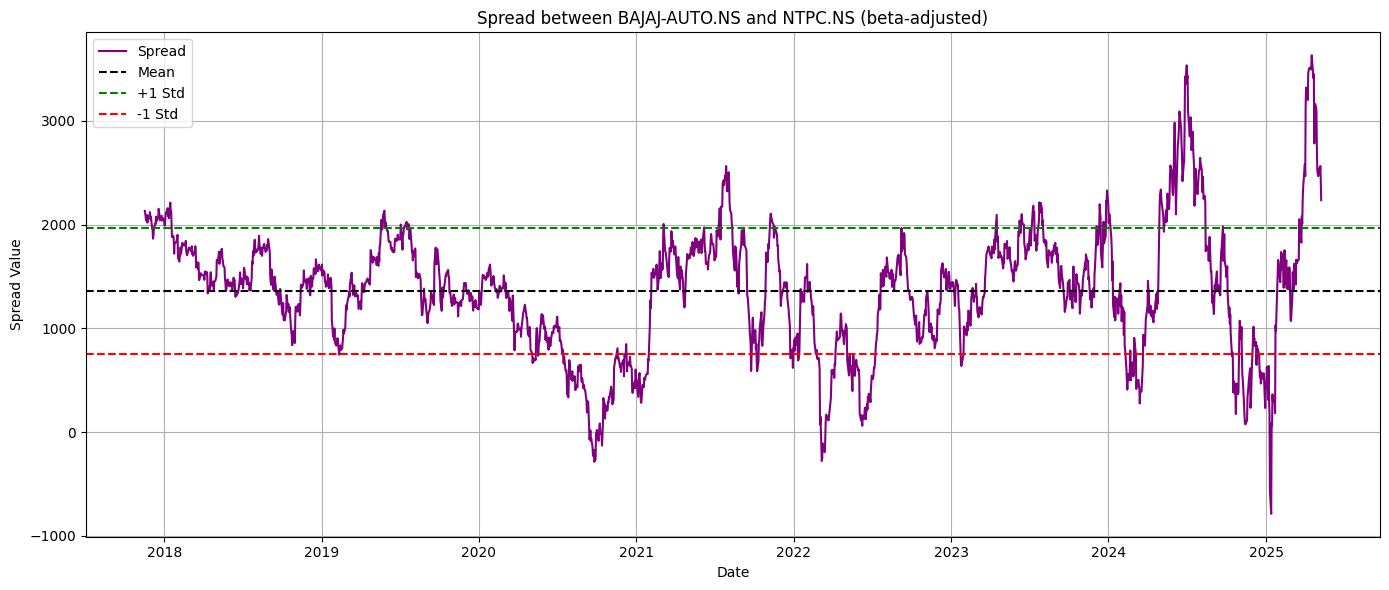

In [9]:


# Plotting the spread 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='purple', linewidth=1.5)
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Std')
plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Std')
plt.title(f'Spread between {stockOne} and {stockTwo} (beta-adjusted)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [10]:


# Proceed with ADFS and KPSS tests

from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(spread)

# adf_t_value = adf_result[0]
# critical_values = adf_result[4]

# If for any of the values, if adf_t_value < any of the critical values. Then we reject null hypothesis is adf test

adf_p_value = adf_result[1]

kpss_p_value = kpss(spread, regression='c')[1]

print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")
if adf_p_value < 0.05 and kpss_p_value > 0.05:
  print("The spread is stationary. Proceed with trading.")
else:
  print("The spread is not stationary. Do not trade this pair.")



ADF p-value: 0.0005340649569222206
KPSS p-value: 0.1
The spread is stationary. Proceed with trading.


/var/folders/vk/pts8jzrx7hlbjvh9g2rsc65w0000gn/T/ipykernel_4769/4079035811.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


In [11]:
# Finding the mean value of the spread to identify what is the average value
# of the difference b/w stock X and Y

mean_spread = spread.rolling(30).mean()
std_spread = spread.rolling(30).std()

zscore = (spread - mean_spread) / std_spread



In [12]:

## Checking if there are any opportunities with z-score > +2 ? or z-score < -2

extreme_zscores = zscore[(zscore > 2) | (zscore < -2)]

print(extreme_zscores)

if not extreme_zscores.empty:
  print("There are extreme z-score entries (> 2 or < -2).")
else:
  print("No extreme z-score entries found.")


Date
2018-01-15    2.160218
2018-01-19   -2.773163
2018-01-22   -2.414241
2018-01-23   -2.431647
2018-01-24   -3.270984
                ...   
2025-04-02    2.012887
2025-04-03    3.030756
2025-04-04    2.796485
2025-04-07    2.367816
2025-04-09    2.119403
Length: 241, dtype: float64
There are extreme z-score entries (> 2 or < -2).


In [13]:
# Individual stocks mean reversion ???